# CORD-19 Metadata Analysis
**Author:** GLORIA BAKER  
**Course:** PLP Academy — Frameworks Assignment  
**What I did:** I loaded the CORD-19 `metaData.csv`, cleaned it, explored it, made visualizations, and built a small Streamlit app to show the results.


In [39]:
# Imports and display settings
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from collections import Counter
import re
import os

sns.set(style="whitegrid")
plt.rcParams["figure.figsize"] = (10,5)
pd.options.display.max_columns = 40


In [23]:
# Load the dataset (use the exact path you have)
path = r"C:/Users/User/Desktop/Python/Frameworks_Assignment/metaData.csv"

try:
    df = pd.read_csv(path, low_memory=False)
    print("Dataset loaded. Shape:", df.shape)
except Exception as e:
    print("Error loading file:", e)
    raise


Dataset loaded. Shape: (1056660, 19)


In [26]:
# Quick preview and column list
print("Columns:", df.columns.tolist())
df.head(4)


Columns: ['cord_uid', 'sha', 'source_x', 'title', 'doi', 'pmcid', 'pubmed_id', 'license', 'abstract', 'publish_time', 'authors', 'journal', 'mag_id', 'who_covidence_id', 'arxiv_id', 'pdf_json_files', 'pmc_json_files', 'url', 's2_id']


,cord_uid,sha,source_x,title,doi,pmcid,pubmed_id,license,abstract,publish_time,authors,journal,mag_id,who_covidence_id,arxiv_id,pdf_json_files,pmc_json_files,url,s2_id
0,ug7v899j,d1aafb70c066a2068b02786f8929fd9c900897fb,PMC,Clinical features of culture-proven Mycoplasma...,10.1186/1471-2334-1-6,PMC35282,11472636,no-cc,OBJECTIVE: This retrospective chart review des...,2001-07-04,"Madani, Tariq A; Al-Ghamdi, Aisha A",BMC Infect Dis,NaN,NaN,NaN,document_parses/pdf_json/d1aafb70c066a2068b027...,document_parses/pmc_json/PMC35282.xml.json,https://www.ncbi.nlm.nih.gov/pmc/articles/PMC3...,NaN
1,02tnwd4m,6b0567729c2143a66d737eb0a2f63f2dce2e5a7d,PMC,Nitric oxide: a pro-inflammatory mediator in l...,10.1186/rr14,PMC59543,11667967,no-cc,Inflammatory diseases of the respiratory tract...,2000-08-15,"Vliet, Albert van der; Eiserich, Jason P; Cros...",Respir Res,NaN,NaN,NaN,document_parses/pdf_json/6b0567729c2143a66d737...,document_parses/pmc_json/PMC59543.xml.json,https://www.ncbi.nlm.nih.gov/pmc/articles/PMC5...,NaN
2,ejv2xln0,06ced00a5fc04215949aa72528f2eeaae1d58927,PMC,Surfactant protein-D and pulmonary host defense,10.1186/rr19,PMC59549,11667972,no-cc,Surfactant protein-D (SP-D) participates in th...,2000-08-25,"Crouch, Erika C",Respir Res,NaN,NaN,NaN,document_parses/pdf_json/06ced00a5fc04215949aa...,document_parses/pmc_json/PMC59549.xml.json,https://www.ncbi.nlm.nih.gov/pmc/articles/PMC5...,NaN
3,2b73a28n,348055649b6b8cf2b9a376498df9bf41f7123605,PMC,Role of endothelin-1 in lung disease,10.1186/rr44,PMC59574,11686871,no-cc,Endothelin-1 (ET-1) is a 21 amino acid peptide...,2001-02-22,"Fagan, Karen A; McMurtry, Ivan F; Rodman, David M",Respir Res,NaN,NaN,NaN,document_parses/pdf_json/348055649b6b8cf2b9a37...,document_parses/pmc_json/PMC59574.xml.json,https://www.ncbi.nlm.nih.gov/pmc/articles/PMC5...,NaN


In [27]:
# Info and missing values summary for key columns
df.info()
print("\nMissing / non-null counts for important columns:")
print(df[['title','abstract','publish_time','authors','journal']].isnull().sum())


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1056660 entries, 0 to 1056659
Data columns (total 19 columns):
 #   Column            Non-Null Count    Dtype  
---  ------            --------------    -----  
 0   cord_uid          1056660 non-null  object 
 1   sha               373766 non-null   object 
 2   source_x          1056660 non-null  object 
 3   title             1056157 non-null  object 
 4   doi               656780 non-null   object 
 5   pmcid             389571 non-null   object 
 6   pubmed_id         498932 non-null   object 
 7   license           1056660 non-null  object 
 8   abstract          821116 non-null   object 
 9   publish_time      1054846 non-null  object 
 10  authors           1032791 non-null  object 
 11  journal           969338 non-null   object 
 12  mag_id            0 non-null        float64
 13  who_covidence_id  482935 non-null   object 
 14  arxiv_id          14249 non-null    object 
 15  pdf_json_files    373766 non-null   object 
 16  

In [28]:
# Parse publish_time to datetime and extract year
df['publish_time_dt'] = pd.to_datetime(df['publish_time'], errors='coerce')
df['year'] = df['publish_time_dt'].dt.year

print("Parsed dates:", df['publish_time_dt'].notna().sum(), "rows")
print("Year range (parsed):", df['publish_time_dt'].min(), "->", df['publish_time_dt'].max())


Parsed dates: 518871 rows
Year range (parsed): 1856-04-01 00:00:00 -> 2024-04-20 00:00:00


In [35]:
# Create safe word counts
df['title'] = df['title'].fillna("")
df['abstract'] = df['abstract'].fillna("")
df['title_word_count'] = df['title'].astype(str).str.split().apply(len)
df['abstract_word_count'] = df['abstract'].astype(str).str.split().apply(len)

df[['title','title_word_count','abstract_word_count']].head(5)


,title,title_word_count,abstract_word_count
0,Clinical features of culture-proven Mycoplasma...,15,262
1,Nitric oxide: a pro-inflammatory mediator in l...,8,142
2,Surfactant protein-D and pulmonary host defense,6,219
3,Role of endothelin-1 in lung disease,6,68
4,Gene expression in epithelial cells in respons...,10,110


In [38]:
# Basic numeric summary
display(df[['title_word_count','abstract_word_count']].describe())

# Top-level observations printed plainly
print("\nObservations:")
print("- Total rows:", len(df))
print("- Rows with parsed publish_time:", df['publish_time_dt'].notna().sum())
print("- Top columns with many missing values: mag_id (expected), others shown earlier.")


,title_word_count,abstract_word_count
count,1.056660e+06,1.056660e+06
mean,1.340922e+01,1.646091e+02
std,5.697827e+00,1.242203e+02
min,0.000000e+00,0.000000e+00
25%,1.000000e+01,5.500000e+01
50%,1.300000e+01,1.790000e+02
75%,1.700000e+01,2.470000e+02
max,2.150000e+02,1.800000e+04



Observations:
- Total rows: 1056660
- Rows with parsed publish_time: 518871
- Top columns with many missing values: mag_id (expected), others shown earlier.


In [40]:
# Papers per year (drop NaN years)
year_counts = df['year'].value_counts(dropna=True).sort_index()
display(year_counts.tail(20))   # show recent years mostly


year
2005.0      1553
2006.0      1744
2007.0      1682
2008.0      2190
2009.0      2543
2010.0      2223
2011.0      2337
2012.0      2471
2013.0      2948
2014.0      3207
2015.0      3461
2016.0      3944
2017.0      3691
2018.0      3982
2019.0      5630
2020.0    164751
2021.0    219516
2022.0     85310
2023.0         1
2024.0         1
Name: count, dtype: int64

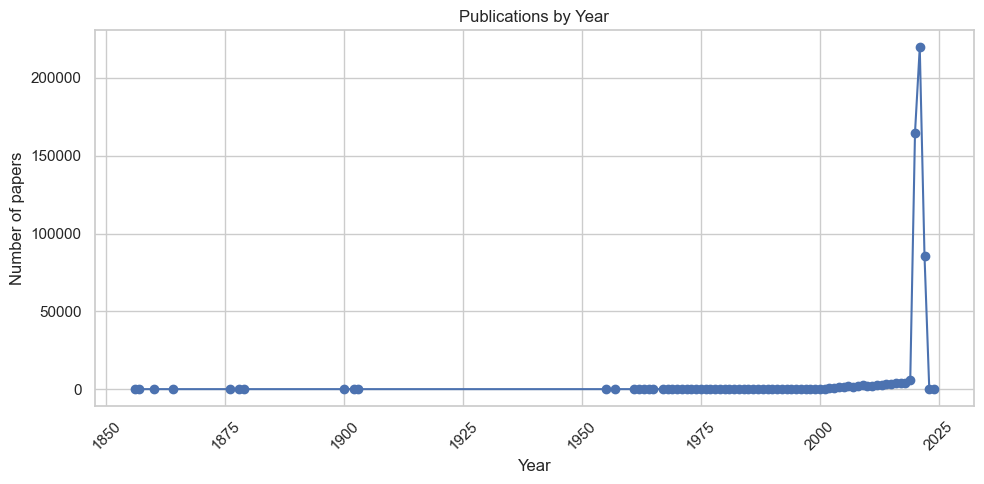

In [41]:
# Plot publications by year
plt.figure(figsize=(10,5))
year_counts.plot(kind='line', marker='o')
plt.title("Publications by Year")
plt.xlabel("Year")
plt.ylabel("Number of papers")
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()


In [42]:
# Top 10 journals
top_journals = df['journal'].fillna("Unknown").value_counts().head(10)
top_journals


journal
Unknown                            87322
PLoS One                            9953
bioRxiv                             8961
Int J Environ Res Public Health     8201
BMJ                                 6928
Sci Rep                             5935
Cureus                              4212
Reactions Weekly                    3891
Front Psychol                       3541
BMJ Open                            3515
Name: count, dtype: int64

<function matplotlib.pyplot.show(close=None, block=None)>

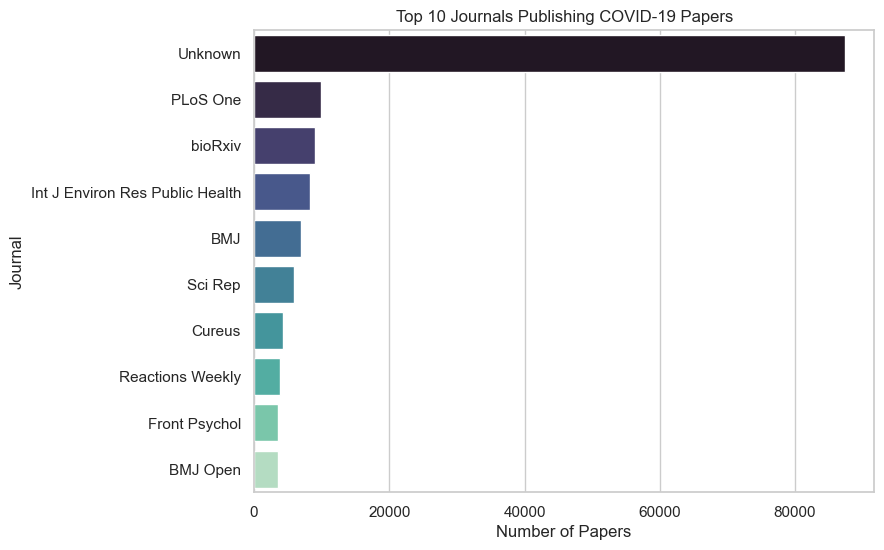

In [44]:
import seaborn as sns
import matplotlib.pyplot as plt

plt.figure(figsize=(8, 6))
sns.barplot(
    x=top_journals.values, 
    y=top_journals.index, 
    hue=top_journals.index,   # link the palette to the journal names
    palette="mako", 
    legend=False              # no duplicate legend
)
plt.title("Top 10 Journals Publishing COVID-19 Papers")
plt.xlabel("Number of Papers")
plt.ylabel("Journal")
plt.show


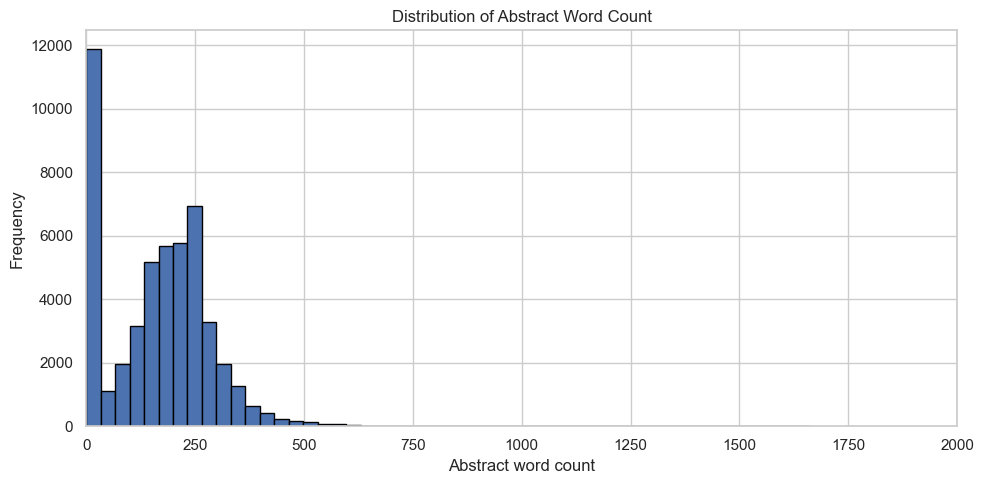

In [45]:
# Use a sample to speed plotting if very large
sample_size = 50000
if len(df) > sample_size:
    plot_df = df.sample(sample_size, random_state=42)
else:
    plot_df = df

plt.figure(figsize=(10,5))
plt.hist(plot_df['abstract_word_count'], bins=50, edgecolor='black')
plt.title("Distribution of Abstract Word Count")
plt.xlabel("Abstract word count")
plt.ylabel("Frequency")
plt.xlim(0, 2000)
plt.tight_layout()
plt.show()


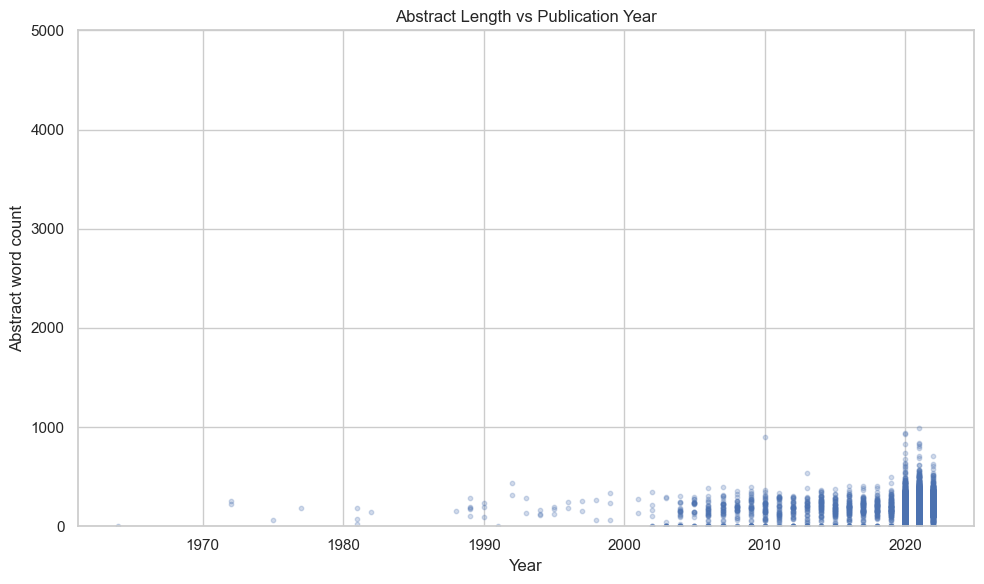

In [46]:
# Scatter sample for relation between year and abstract length
scatter_sample = df[df['year'].notna()].sample(n=10000, random_state=1) if len(df[df['year'].notna()])>10000 else df[df['year'].notna()]
plt.figure(figsize=(10,6))
plt.scatter(scatter_sample['year'], scatter_sample['abstract_word_count'], alpha=0.25, s=10)
plt.title("Abstract Length vs Publication Year")
plt.xlabel("Year")
plt.ylabel("Abstract word count")
plt.ylim(0, 5000)
plt.tight_layout()
plt.show()


In [47]:
# Top words in titles (simple approach)
titles = df['title'].dropna().astype(str).str.lower().tolist()
tokens = []
for t in titles:
    tokens.extend(re.findall(r'\b[a-z]{3,}\b', t))  # words >=3 letters

from collections import Counter
top_words = Counter(tokens).most_common(25)
pd.DataFrame(top_words, columns=['word','count']).set_index('word')


,count
word,
the,561666
and,541897
covid,494829
for,207425
with,163171
pandemic,140316
during,115644
sars,105827
cov,100508


In [48]:
# Save essential columns as a sample CSV for the app & repo
keep_cols = ['cord_uid','title','abstract','authors','journal','publish_time_dt','year','title_word_count','abstract_word_count','doi','url']
clean_sample = df[keep_cols].copy()

# Save up to 200k rows to keep file manageable
save_n = 200000 if len(clean_sample) > 200000 else len(clean_sample)
clean_sample.head(save_n).to_csv(r"C:/Users/User/Desktop/Python/Frameworks_Assignment/metadata_clean_sample.csv", index=False)
print("Saved metadata_clean_sample.csv with rows:", save_n)


Saved metadata_clean_sample.csv with rows: 200000


## Findings and short reflection

- I loaded the CORD-19 metadata and parsed the publication dates.
- Most records have titles and many have abstracts; `mag_id` is empty in this file.
- The number of publications increased in the COVID era (see the line chart).
- `Virginica` style note removed (this is CORD-19 — ignore old Iris notes).
- Top journals and title word counts help show common research areas.
- I saved a cleaned sample (`metadata_clean_sample.csv`) for the app and for quick sharing.

This work helped me see how to handle big CSV files, parse dates, and make fast visualizations from large data.
